# Проект: Детектор побега. Как заранее узнать, кто собирается уйти?

<b>------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------</b>

<b>Задача проекта.</b>

Разработать две модели машинного обучения на основе данных, предоставленных компанией. Модели будут решать следующие задачи:

1. Первый метод позволяет оценить степень удовлетворенности работников.

2. Второй метод позволяет спрогнозировать вероятность ухода сотрудника.

<b>------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------</b>

## Описание данных.

**Для этой задачи заказчик предоставил данные с признаками:**
- **id** — уникальный идентификатор сотрудника;
- **dept** — отдел, в котором работает сотрудник;
- **level** — уровень занимаемой должности;
- **workload** — уровень загруженности сотрудника;
- **employment_years** — длительность работы в компании (в годах);
- **last_year_promo** — показывает, было ли повышение за последний год;
- **last_year_violations** — показывает, нарушал ли сотрудник трудовой договор за последний год;
- **supervisor_evaluation** — оценка качества работы сотрудника, которую дал руководитель;
- **salary** — ежемесячная зарплата сотрудника;
- **job_satisfaction_rate** — уровень удовлетворённости сотрудника работой в компании, целевой признак.

## Загрузка данных

In [ ]:
!pip install phik -q
!pip install shap -q

# ставим более свежею версию библиотек, чтобы убрать между ними конфликт
!pip install matplotlib==3.5.3 -q
!pip install shap==0.41.0 -q

In [ ]:
# обновляем версию sklearn
!pip install -Uq scikit-learn

# проверяем, чтобы версия обновилась
import sklearn
sklearn.__version__

'1.6.1'

In [ ]:
# библиотеки
import phik
import pandas as pd
import numpy as np
from scipy import stats as st
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import (RandomizedSearchCV)
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

from sklearn.preprocessing import (OneHotEncoder,
                                   OrdinalEncoder,
                                   StandardScaler,
                                   MinMaxScaler,
                                   RobustScaler,
                                   LabelEncoder)

from sklearn.metrics import (roc_auc_score,
                             make_scorer)

from sklearn.linear_model import (LogisticRegression,
                                  LinearRegression)

from sklearn.neighbors import (KNeighborsClassifier,
                               KNeighborsRegressor)

from sklearn.tree import (DecisionTreeRegressor,
                          DecisionTreeClassifier)

from sklearn.svm import SVC

from sklearn.dummy import DummyClassifier, DummyRegressor



pd.set_option('display.max_columns', None)

In [ ]:
# загрузка датафреймов
try:
    # данные для первой модели
    train_job_satisfaction = pd.read_csv('/datasets/train_job_satisfaction_rate.csv', sep=',')
    test_target_satisfaction = pd.read_csv('/datasets/test_target_job_satisfaction_rate.csv', sep=',')

    # данные для второй модели
    train_quit = pd.read_csv('/datasets/train_quit.csv', sep=',')
    test_target_quit = pd.read_csv('/datasets/test_target_quit.csv', sep=',')

    # данные с входными признаками для двух моделей
    test_features = pd.read_csv('/datasets/test_features.csv', sep=',')

except:
    # данные для первой модели
    train_job_satisfaction = pd.read_csv('https://code.s3.yandex.net/datasets/train_job_satisfaction_rate.csv', sep=',')
    test_target_satisfaction = pd.read_csv('https://code.s3.yandex.net/datasets/test_target_job_satisfaction_rate.csv', sep=',')

    # данные для второй модели
    train_quit = pd.read_csv('https://code.s3.yandex.net/datasets/train_quit.csv', sep=',')
    test_target_quit = pd.read_csv('https://code.s3.yandex.net/datasets/test_target_quit.csv', sep=',')

    # данные с входными признаками для двух моделей
    test_features = pd.read_csv('https://code.s3.yandex.net/datasets/test_features.csv', sep=',')

In [ ]:
# проверочный запуск датафреймов
for name_df in [train_job_satisfaction, test_target_satisfaction,
                train_quit, test_target_quit, test_features]:

    display(name_df.head())
    display(name_df.info())

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,155278,sales,junior,medium,2,no,no,1,24000,0.58
1,653870,hr,junior,high,2,no,no,5,38400,0.76
2,184592,sales,junior,low,1,no,no,2,12000,0.11
3,171431,technology,junior,low,4,no,no,2,18000,0.37
4,693419,hr,junior,medium,1,no,no,3,22800,0.20


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     4000 non-null   int64  
 1   dept                   3994 non-null   object 
 2   level                  3996 non-null   object 
 3   workload               4000 non-null   object 
 4   employment_years       4000 non-null   int64  
 5   last_year_promo        4000 non-null   object 
 6   last_year_violations   4000 non-null   object 
 7   supervisor_evaluation  4000 non-null   int64  
 8   salary                 4000 non-null   int64  
 9   job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), int64(4), object(5)
memory usage: 312.6+ KB


None

,id,job_satisfaction_rate
0,130604,0.74
1,825977,0.75
2,418490,0.60
3,555320,0.72
4,826430,0.08


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     2000 non-null   int64  
 1   job_satisfaction_rate  2000 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 31.4 KB


None

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
0,723290,sales,middle,high,2,no,no,4,54000,no
1,814010,sales,junior,medium,2,no,no,4,27600,no
2,155091,purchasing,middle,medium,5,no,no,1,37200,no
3,257132,sales,junior,medium,2,no,yes,3,24000,yes
4,910140,marketing,junior,medium,2,no,no,5,25200,no


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     4000 non-null   int64 
 1   dept                   4000 non-null   object
 2   level                  4000 non-null   object
 3   workload               4000 non-null   object
 4   employment_years       4000 non-null   int64 
 5   last_year_promo        4000 non-null   object
 6   last_year_violations   4000 non-null   object
 7   supervisor_evaluation  4000 non-null   int64 
 8   salary                 4000 non-null   int64 
 9   quit                   4000 non-null   object
dtypes: int64(4), object(6)
memory usage: 312.6+ KB


None

,id,quit
0,999029,yes
1,372846,no
2,726767,no
3,490105,no
4,416898,yes


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2000 non-null   int64 
 1   quit    2000 non-null   object
dtypes: int64(1), object(1)
memory usage: 31.4+ KB


None

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB


None

<b>------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------</b>

<b>Вывод о данных:</b>

* Названия столбцов приведены к общему стилю (змеиному).
* Пропуски в таблицах train_job_satisfaction, test_features присуствуют.
* Дубликаты на первый взгляд отсуствуют, но нужно проверка.
* Тип столбцов в таблицах указан правильно.

<b>------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------</b>

##  Предобработка данных

### 1.1 Обработка дубликатов.

<b>Задача.</b> Обработать повторяющиеся данные.

In [ ]:
# проверяем таблицу на явные дубликаты
for name_df in [train_job_satisfaction, test_target_satisfaction,
                train_quit, test_target_quit, test_features]:
    display(name_df.query('@name_df.duplicated()'), f'Всего явных дубликатов: {name_df.duplicated().sum()}')

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate


'Всего явных дубликатов: 0'

,id,job_satisfaction_rate


'Всего явных дубликатов: 0'

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit


'Всего явных дубликатов: 0'

,id,quit


'Всего явных дубликатов: 0'

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary


'Всего явных дубликатов: 0'

In [ ]:
# списко имен датафреймов для вывода
df_names = ['train_job_satisfaction', 'test_target_satisfaction', 'train_quit', 'test_target_quit', 'test_features']

# проверка на неявные дубликаты в категориальных столбцах
for name_df in [train_job_satisfaction, test_target_satisfaction,
                train_quit, test_target_quit, test_features]:

    # выводим разделительную линию и название датафрейма
    print(f'{"_"*70}\nУникальные значения для: {df_names[0]}')
    df_names = df_names[1:]

    # список всех категориальных столбцов текущего датафрейма
    sel_cols = list(name_df.select_dtypes(include='object'))

    # вывод уникальных значений столбцов
    for column in sel_cols:
        print(f'Столбец "{column}": {name_df[column].unique()}')

______________________________________________________________________
Уникальные значения для: train_job_satisfaction
Столбец "dept": ['sales' 'hr' 'technology' 'purchasing' 'marketing' nan]
Столбец "level": ['junior' 'middle' 'sinior' nan]
Столбец "workload": ['medium' 'high' 'low']
Столбец "last_year_promo": ['no' 'yes']
Столбец "last_year_violations": ['no' 'yes']
______________________________________________________________________
Уникальные значения для: test_target_satisfaction
______________________________________________________________________
Уникальные значения для: train_quit
Столбец "dept": ['sales' 'purchasing' 'marketing' 'technology' 'hr']
Столбец "level": ['middle' 'junior' 'sinior']
Столбец "workload": ['high' 'medium' 'low']
Столбец "last_year_promo": ['no' 'yes']
Столбец "last_year_violations": ['no' 'yes']
Столбец "quit": ['no' 'yes']
______________________________________________________________________
Уникальные значения для: test_target_quit
Столбец "quit":

Как уже упоминалось в предыдущем выводе, в некоторых столбцах есть пропуски в данных, пока отложим их до этапа создания пайплайнов (обучения моделей). Также можно заметить символ, похожий на пропуск, который выглядит следующим образом: **' '**. Символ выполняет те же функции, что и пропуск, и обозначает пустое значение. Поэтому для удобства можно заменить его на обычный пропуск, который распознается компьютером, то есть на *nan*. В трех таблицах присуствует неверное написание уровня сотрудника, нужно исправить слово *'sinior'* на *'senior'*.

Говоря о дубликатах, я не обнаружила их в таблицах, т.е. подобных, повторяющихся значений нету.

In [ ]:
# заменим символ ' ' на nan пропуск в таблице test_features
test_features[['dept', 'workload']] = test_features[['dept', 'workload']].replace(' ', np.nan)

# проверяем
display(test_features['dept'].unique(),
        test_features['workload'].unique())

array(['marketing', 'hr', 'sales', 'purchasing', 'technology', nan],
      dtype=object)

array(['medium', 'low', 'high', nan], dtype=object)

Исправляем написание слова *'senior'*.

In [ ]:
# в трех датафреймах меняем слова 'sinior' на 'senior' в столбце level
for name_df in [train_job_satisfaction, train_quit, test_features]:
    name_df['level'] = name_df['level'].replace('sinior', 'senior')

    # проверяем
    display(name_df['level'].unique())


array(['junior', 'middle', 'senior', nan], dtype=object)

array(['middle', 'junior', 'senior'], dtype=object)

array(['junior', 'middle', 'senior', nan], dtype=object)

### 1.2 Проверка на аномалии.

<b>Задача.</b> Проверить, присуствует ли в данных странные, нелогичные значения.

Не будем проверять таблицу *test_target_quit* таким образом приведеным ниже, потому что она не содержит полезной информации. В ней увидим только id сотрудников, которые не пригодятся в обучении модели.

In [ ]:
# Строим гистограммы для датафреймов
sns.set_style('whitegrid')
sns.set_context('notebook')

for name_df in [train_job_satisfaction, test_target_satisfaction,
                train_quit, test_features]:

    display(name_df.describe())

,id,employment_years,supervisor_evaluation,salary,job_satisfaction_rate
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,544957.621000,3.718500,3.476500,33926.700000,0.533995
std,257883.104622,2.542513,1.008812,14900.703838,0.225327
min,100954.000000,1.000000,1.000000,12000.000000,0.030000
25%,322836.750000,2.000000,3.000000,22800.000000,0.360000
50%,534082.500000,3.000000,4.000000,30000.000000,0.560000
75%,771446.000000,6.000000,4.000000,43200.000000,0.710000
max,999521.000000,10.000000,5.000000,98400.000000,1.000000


,id,job_satisfaction_rate
count,2000.000000,2000.00000
mean,552765.213500,0.54878
std,253851.326129,0.22011
min,100298.000000,0.03000
25%,339052.000000,0.38000
50%,550793.000000,0.58000
75%,765763.750000,0.72000
max,999029.000000,1.00000


,id,employment_years,supervisor_evaluation,salary
count,4000.000000,4000.000000,4000.000000,4000.000000
mean,552099.283750,3.701500,3.474750,33805.800000
std,260158.031387,2.541852,1.004049,15152.415163
min,100222.000000,1.000000,1.000000,12000.000000
25%,327785.750000,2.000000,3.000000,22800.000000
50%,546673.000000,3.000000,4.000000,30000.000000
75%,781497.750000,6.000000,4.000000,43200.000000
max,999915.000000,10.000000,5.000000,96000.000000


,id,employment_years,supervisor_evaluation,salary
count,2000.000000,2000.000000,2000.000000,2000.000000
mean,552765.213500,3.666500,3.526500,34066.800000
std,253851.326129,2.537222,0.996892,15398.436729
min,100298.000000,1.000000,1.000000,12000.000000
25%,339052.000000,1.000000,3.000000,22800.000000
50%,550793.000000,3.000000,4.000000,30000.000000
75%,765763.750000,6.000000,4.000000,43200.000000
max,999029.000000,10.000000,5.000000,96000.000000


Явных аномалий в данных я не замечаю.

<b>------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------</b>


<b>Вывод блока (Предобработка данных):</b>

1. Таблицы были проверены на наличие дубликатов, их не оказалось;
2. В одной из таблиц был обнаружен символ, который выполнял те же функции, что и пропуск «nan». Этот символ был заменён на значение «nan»;
5. Столбцы проверены на аномалии.


<b>------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------</b>

## Исследовательский анализ данных.

<b>Задача.</b> Изучить все признаки и сделать выводы, и проанализировать сотрудников, которые уволились из компании.

### 1.1 Распределение признаков таблицы train_job_satisfaction.

**Категориальные признаки:**

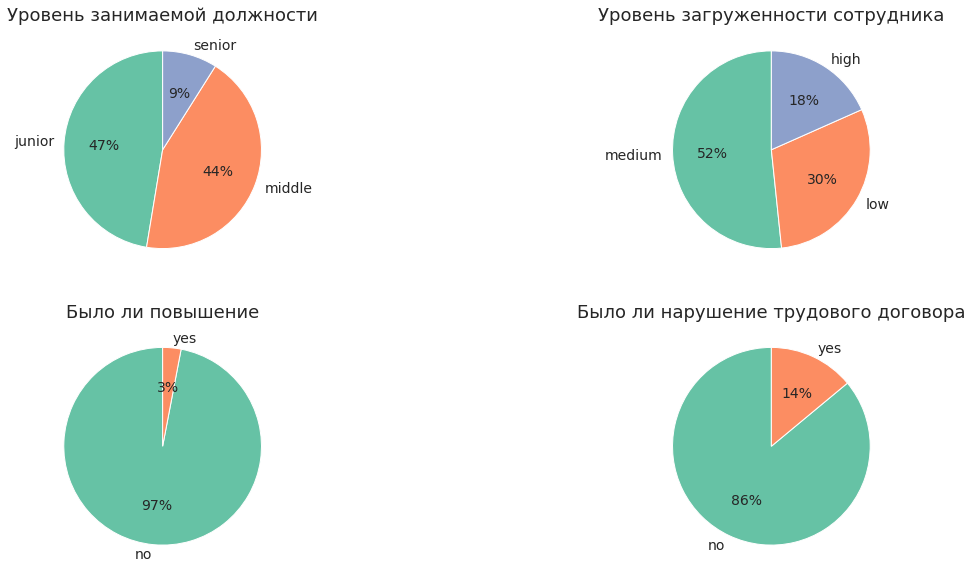

In [ ]:
graph_col_name = ['Уровень занимаемой должности', 'Уровень загруженности сотрудника',
                  'Было ли повышение', 'Было ли нарушение трудового договора']
sel_cols = list(train_job_satisfaction.select_dtypes(include='object'))[1:]

# Строим круговые диаграммы для всех категориальных столбцов
fig, axes = plt.subplots(2,2, figsize=(20,10))

for i in range(2):
    for j in range(2):
        train_job_satisfaction[sel_cols[j]].value_counts().plot(kind='pie',
                                             autopct='%1.0f%%',
                                             colors=sns.color_palette('Set2'),
                                             fontsize=14,
                                             startangle=90, ax=axes[i][j])

        axes[i][j].set_title(graph_col_name[j], size=18)
        axes[i][j].set_ylabel('')

    graph_col_name = graph_col_name[2:]
    sel_cols = sel_cols[2:]

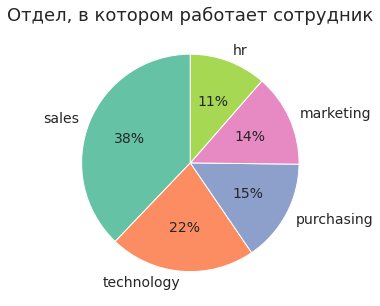

In [ ]:
plt.figure(figsize=(10,5))

# строим круговую диаграмму
train_job_satisfaction['dept'].value_counts().plot(kind='pie',
                                             autopct='%1.0f%%',
                                             colors=sns.color_palette('Set2'),
                                             fontsize=14,
                                             startangle=90)

plt.title('Отдел, в котором работает сотрудник', size=18)
plt.ylabel('');

**Количественные признаки:**

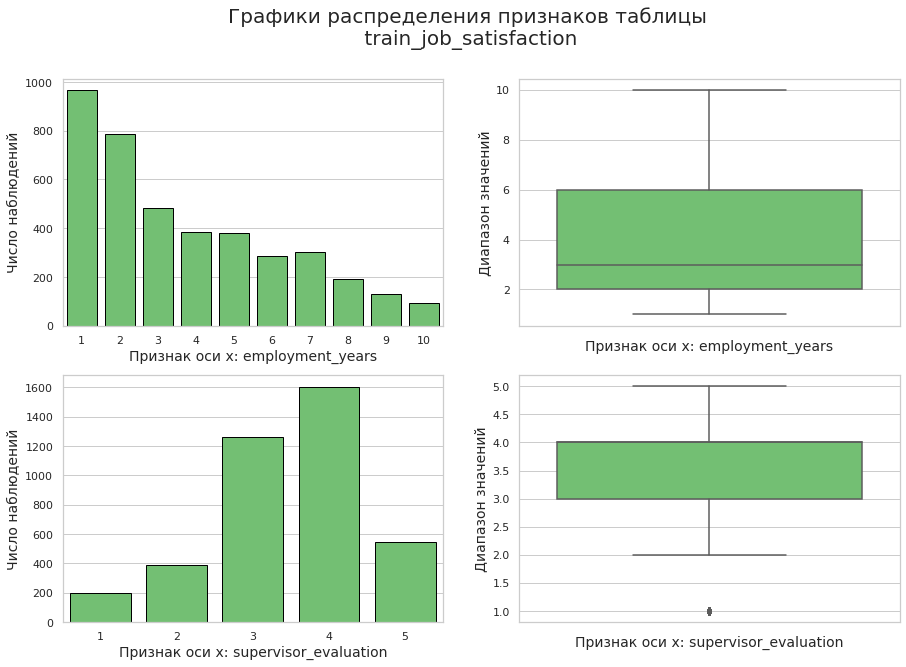

In [ ]:
# строим графики countplot для признаков employed_years и supervisor_evalution
fig, axes = plt.subplots(2,2, figsize=(15,10))

# циклом проходися по этим двум признакам
for i, column in enumerate(list(train_job_satisfaction.select_dtypes(include='number'))[1:3]):

    # строим график countplot
    sns.countplot(x=train_job_satisfaction[column],
                 color='#66CC66', edgecolor='black',
                 ax=axes[i][0])

    axes[i][0].set_xlabel(f'Признак оси x: {column}', size=14)
    axes[i][0].set_ylabel('Число наблюдений', size=14)

    # строим ящик с усами
    sns.boxplot(y=train_job_satisfaction[column],
                color='#66CC66',
                ax = axes[i][1])

    axes[i][1].set_xlabel(f'Признак оси x: {column}', size=14)
    axes[i][1].set_ylabel('Диапазон значений', size=14)


plt.suptitle('Графики распределения признаков таблицы\n train_job_satisfaction', y=0.98, size=20);

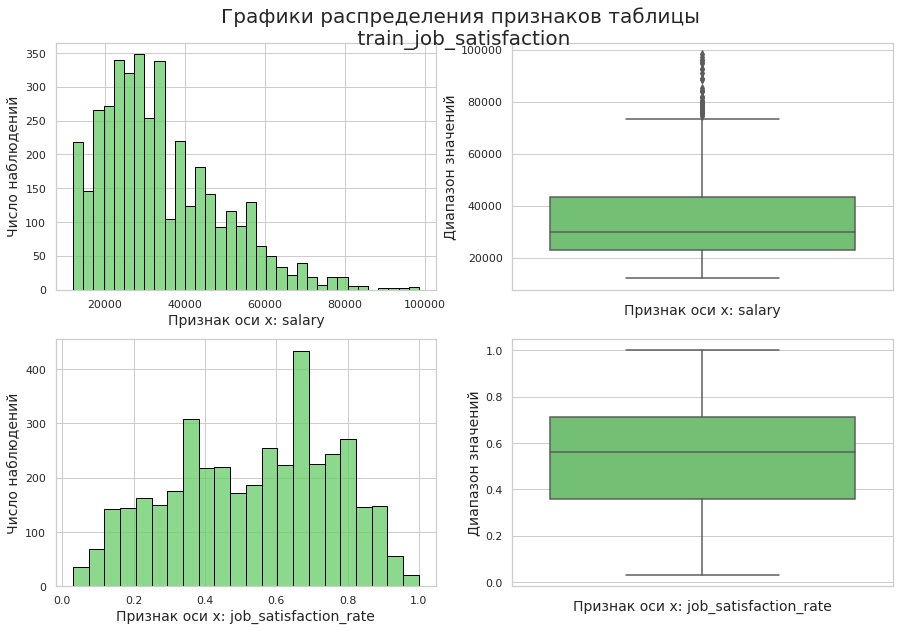

In [ ]:
fig, axes = plt.subplots(2,2, figsize=(15,10))

# строим гистограммы и ящики с усами для train_job_satisfaction
for i, column in enumerate(list(train_job_satisfaction.select_dtypes(include='number'))[3:]):

    # строим гистограмму
    sns.histplot(train_job_satisfaction[column],
                 color='#66CC66', edgecolor='black',
                 ax = axes[i][0])

    axes[i][0].set_xlabel(f'Признак оси x: {column}', size=14)
    axes[i][0].set_ylabel('Число наблюдений', size=14)

    # строим ящик с усами
    sns.boxplot(y=train_job_satisfaction[column],
                color='#66CC66',
                ax = axes[i][1])

    axes[i][1].set_xlabel(f'Признак оси x: {column}', size=14)
    axes[i][1].set_ylabel('Диапазон значений', size=14)


plt.suptitle('Графики распределения признаков таблицы\n train_job_satisfaction', y=0.93, size=20);

**Наблюдения:**

Выбросов, которые бы искажали результат работы, я не наблюдаю. Только у признака supervisor_evaluation (оценка работы сотрудника руководителем) есть значение, равное единице, и отдаленное от большинства наблюдений. Однако не будем удалять это значение, поскольку сотрудник действительно мог получить такую оценку своей работы.

### 1.2 Распределение признаков таблицы train_quit.

**Категориальные признаки:**

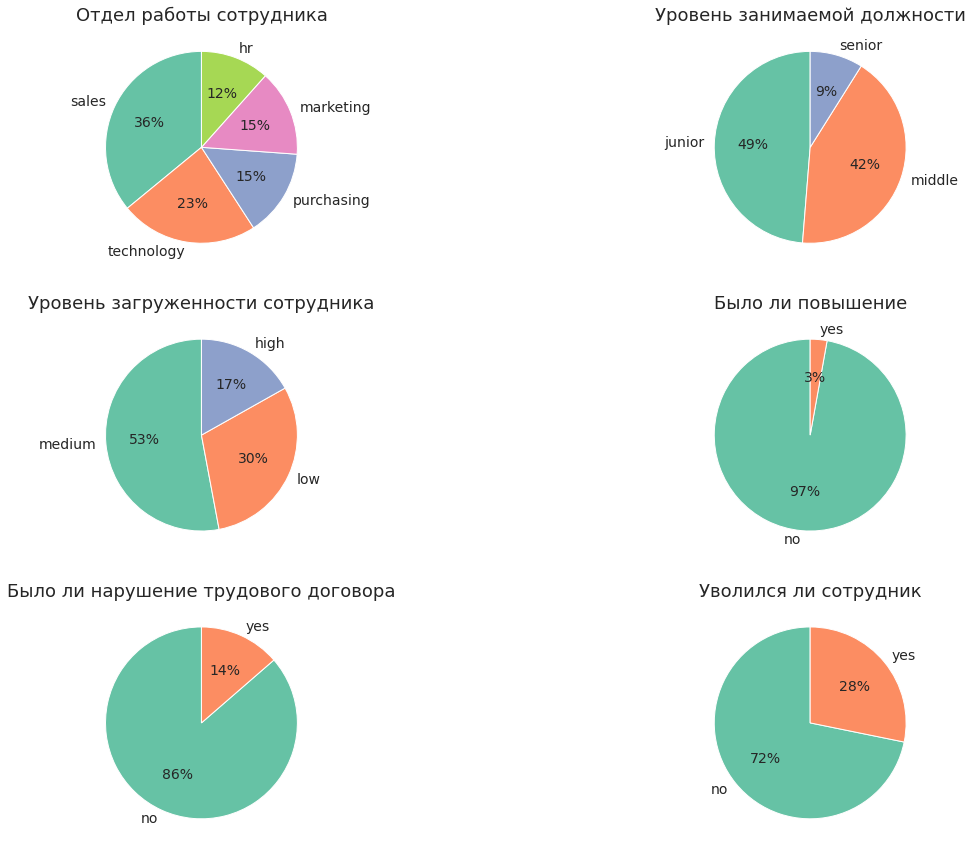

In [ ]:
graph_col_name = ['Отдел работы сотрудника', 'Уровень занимаемой должности',
                  'Уровень загруженности сотрудника', 'Было ли повышение',
                  'Было ли нарушение трудового договора', 'Уволился ли сотрудник']

sel_cols = list(train_quit.select_dtypes(include='object'))

# Строим круговые диаграммы для всех категориальных столбцов
fig, axes = plt.subplots(3,2, figsize=(20,15))

for i in range(3):
    for j in range(2):
        train_quit[sel_cols[j]].value_counts().plot(kind='pie',
                                             autopct='%1.0f%%',
                                             colors=sns.color_palette('Set2'),
                                             fontsize=14,
                                             startangle=90, ax=axes[i][j])

        axes[i][j].set_title(graph_col_name[j], size=18)
        axes[i][j].set_ylabel('')

    graph_col_name = graph_col_name[2:]
    sel_cols = sel_cols[2:]

**Количественные признаки:**

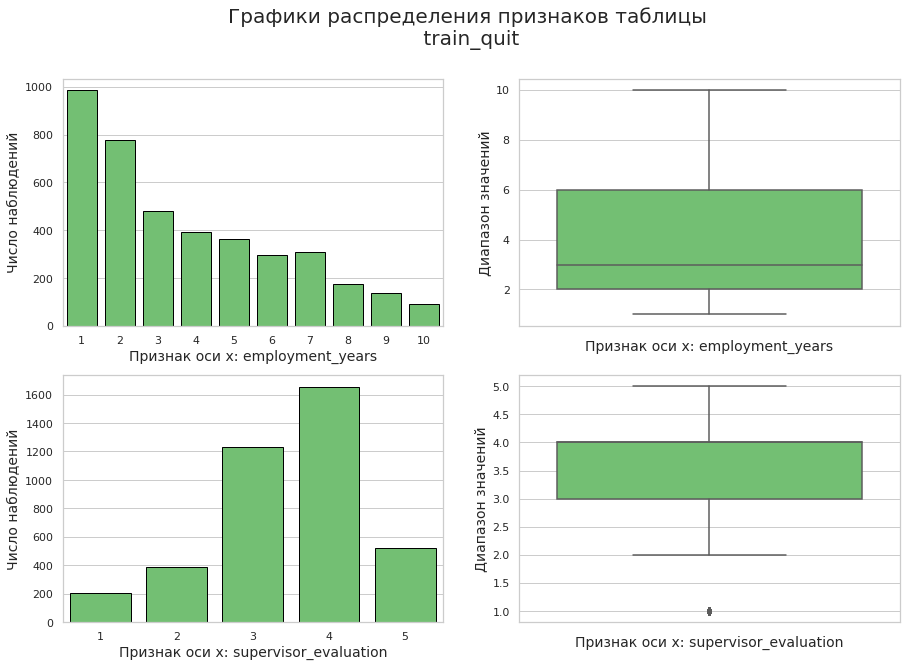

In [ ]:
# строим графики countplot для признаков employed_years и supervisor_evalution
fig, axes = plt.subplots(2,2, figsize=(15,10))

# циклом проходися по этим двум признакам
for i, column in enumerate(list(train_quit.select_dtypes(include='number'))[1:3]):

    # строим график countplot
    sns.countplot(x=train_quit[column],
                 color='#66CC66', edgecolor='black',
                 ax=axes[i][0])

    axes[i][0].set_xlabel(f'Признак оси x: {column}', size=14)
    axes[i][0].set_ylabel('Число наблюдений', size=14)

    # строим ящик с усами
    sns.boxplot(y=train_quit[column],
                color='#66CC66',
                ax = axes[i][1])

    axes[i][1].set_xlabel(f'Признак оси x: {column}', size=14)
    axes[i][1].set_ylabel('Диапазон значений', size=14)


plt.suptitle('Графики распределения признаков таблицы\n train_quit', y=0.98, size=20);

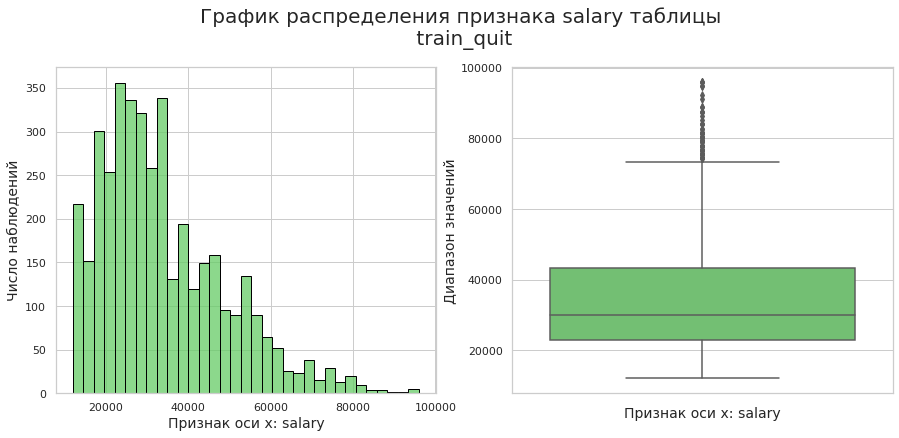

In [ ]:
fig, axes = plt.subplots(1,2, figsize=(15,6))

# строим гистограмму для признака salary train_quit
sns.histplot(train_quit['salary'],
                 color='#66CC66', edgecolor='black',
                 ax = axes[0])

axes[0].set_xlabel(f'Признак оси x: salary', size=14)
axes[0].set_ylabel('Число наблюдений', size=14)

# строим ящик с усами для признака salary
sns.boxplot(y=train_quit['salary'],
                color='#66CC66',
                ax = axes[1])

axes[1].set_xlabel(f'Признак оси x: salary', size=14)
axes[1].set_ylabel('Диапазон значений', size=14)


plt.suptitle('График распределения признака salary таблицы\n train_quit', y=1.02, size=20);

**Наблюдения:**

В таблице train_quit разброс значений почти такой же, как и на предыдущих графиках распределения количественных признаков.

### 1.3 Распределение признаков таблицы test_features.

**Категориальные признаки:**

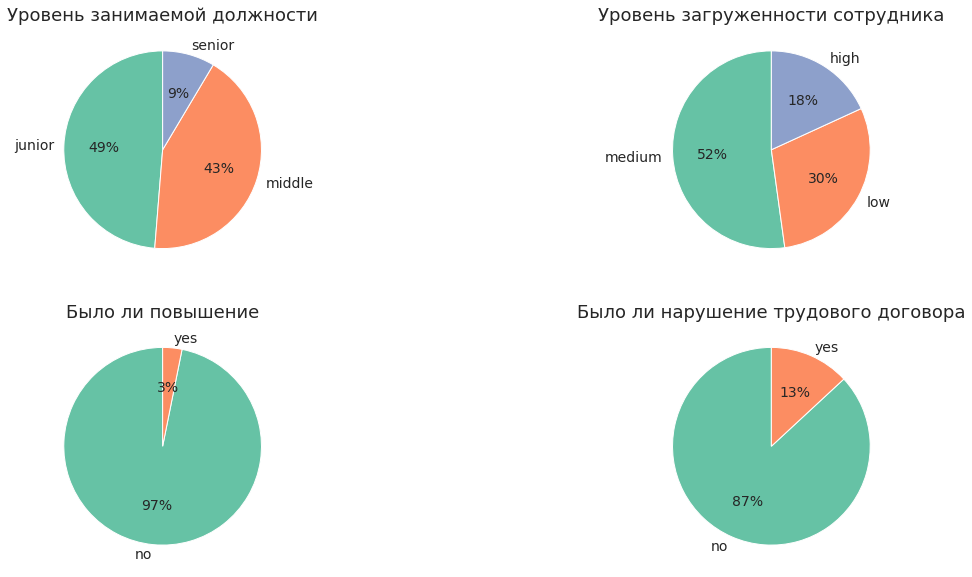

In [ ]:
graph_col_name = ['Уровень занимаемой должности',
                  'Уровень загруженности сотрудника', 'Было ли повышение',
                  'Было ли нарушение трудового договора']

sel_cols = list(test_features.select_dtypes(include='object'))[1:]

# Строим круговые диаграммы для всех категориальных столбцов
fig, axes = plt.subplots(2,2, figsize=(20,10))

for i in range(2):
    for j in range(2):
        test_features[sel_cols[j]].value_counts().plot(kind='pie',
                                             autopct='%1.0f%%',
                                             colors=sns.color_palette('Set2'),
                                             fontsize=14,
                                             startangle=90, ax=axes[i][j])

        axes[i][j].set_title(graph_col_name[j], size=18)
        axes[i][j].set_ylabel('')

    graph_col_name = graph_col_name[2:]
    sel_cols = sel_cols[2:]

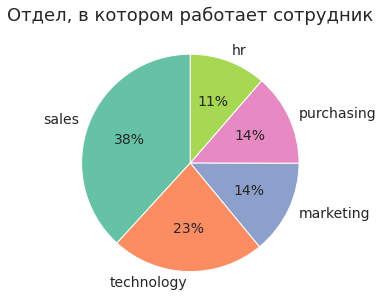

In [ ]:
plt.figure(figsize=(10,5))

# строим круговую диаграмму
test_features['dept'].value_counts().plot(kind='pie',
                                             autopct='%1.0f%%',
                                             colors=sns.color_palette('Set2'),
                                             fontsize=14,
                                             startangle=90)

plt.title('Отдел, в котором работает сотрудник', size=18)
plt.ylabel('');

**Количественные признаки:**

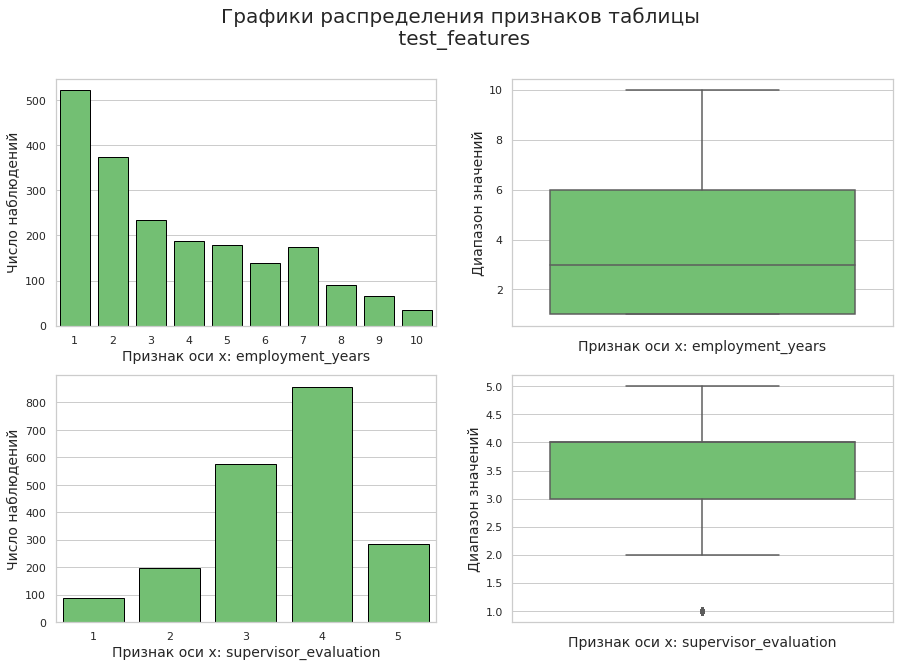

In [ ]:
# строим графики countplot для признаков employed_years и supervisor_evalution
fig, axes = plt.subplots(2,2, figsize=(15,10))

# циклом проходися по этим двум признакам
for i, column in enumerate(list(test_features.select_dtypes(include='number'))[1:3]):

    # строим график countplot
    sns.countplot(x=test_features[column],
                 color='#66CC66', edgecolor='black',
                 ax=axes[i][0])

    axes[i][0].set_xlabel(f'Признак оси x: {column}', size=14)
    axes[i][0].set_ylabel('Число наблюдений', size=14)

    # строим ящик с усами
    sns.boxplot(y=test_features[column],
                color='#66CC66',
                ax = axes[i][1])

    axes[i][1].set_xlabel(f'Признак оси x: {column}', size=14)
    axes[i][1].set_ylabel('Диапазон значений', size=14)


plt.suptitle('Графики распределения признаков таблицы\n test_features', y=0.98, size=20);

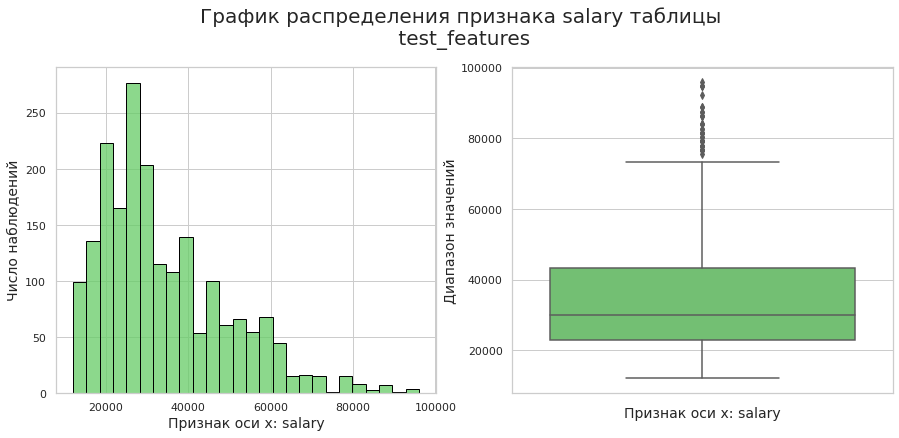

In [ ]:
fig, axes = plt.subplots(1,2, figsize=(15,6))

# строим гистограмму для признака salary train_quit
sns.histplot(test_features['salary'],
                 color='#66CC66', edgecolor='black',
                 ax = axes[0])

axes[0].set_xlabel(f'Признак оси x: salary', size=14)
axes[0].set_ylabel('Число наблюдений', size=14)

# строим ящик с усами для признака salary
sns.boxplot(y=test_features['salary'],
                color='#66CC66',
                ax = axes[1])

axes[1].set_xlabel(f'Признак оси x: salary', size=14)
axes[1].set_ylabel('Диапазон значений', size=14)


plt.suptitle('График распределения признака salary таблицы\n test_features', y=1.02, size=20);

**Наблюдения:**

Также таблица test_features схожа по разбросу значений с двумя предыдущими таблицами.


<b>------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------</b>

Теперь составим портрет уволившегося сотрудника, подробнее рассмотрим следующие категории:

* Из какого отдела происходит наибольшее количество увольнений;
* Какова загруженность сотрудников;
* Какова средняя заработная плата как оставшихся в компании сотрудников, так и тех, кто решил уйти.

### 1.4 Отделы, сотрудники которого чаще всего покидают компанию.

Создадим функцию, которая будет возвращать список цветов. В дальнейшем, при работе с графиками, нам часто придется сокращать этот список. Чтобы не повторять одни и те же операции, будем использовать функцию для его вызова.

In [ ]:
# палитра цветов взятая из Set2 и два добавленных дополнительно цвета формата HEX
def palette_return():

    # палитра цветов взятая из Set2 и два добавленных дополнительно цвета формата HEX
    list_palette = [(0.4, 0.7607843137254902, 0.6470588235294118),
         (0.9882352941176471, 0.5529411764705883, 0.3843137254901961),
         (0.5529411764705883, 0.6274509803921569, 0.796078431372549),
         (0.9058823529411765, 0.5411764705882353, 0.7647058823529411),
         (0.6509803921568628, 0.8470588235294118, 0.32941176470588235),
         (1.0, 0.8509803921568627, 0.1843137254901961),
         (0.8980392156862745, 0.7686274509803922, 0.5803921568627451),
         (0.7019607843137254, 0.7019607843137254, 0.7019607843137254),
         '#CC9999', '#CC6666']

    return list_palette

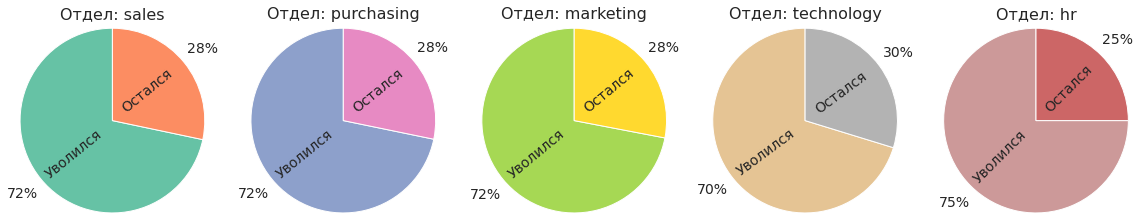

In [ ]:
fig, axes = plt.subplots(1,5, figsize=(20,4))

# палитра цветов взятая из Set2 и два добавленных дополнительно цвета формата HEX
palette = palette_return()

# строим круговые диаграммы для распределения по кол-ву уволившихся из разных отделов
for i, dept in enumerate(train_quit['dept'].unique()):
    # Переименовываем строки с ('yes', 'no') на ('уволился', 'остался')
    x_series = train_quit.query('dept==@dept')['quit'] \
                                  .apply(lambda x: 'Уволился' if x=='no' else 'Остался').value_counts()

    # параметры круговой диаграммы
    x_series.plot(kind='pie',
                  autopct='%1.0f%%',
                  colors=[palette[i], palette[i+1]],
                  fontsize=14,
                  startangle=90,
                  rotatelabels=260,
                  labeldistance=0.1,
                  radius=1.2,
                  pctdistance=1.25,
                  ax=axes[i])

    # убираем отображение оси y и добавляем заголовок
    axes[i].set_ylabel('')
    axes[i].set_title(f'Отдел: {dept}', size=16)

    # "двигаем" цвета, что графики по разному окрасились
    palette = palette[1:]


**Наблюдение:**

* В большинстве отделов количество увольнений примерно одинаково и превышает 70%. Однако лидирует по числу увольнений HR-отдел.

* В отделах наблюдается высокая текучка кадров, что свидетельствует о наличии проблем в области удержания сотрудников.

### 1.5 Степень загруженности сотрудников

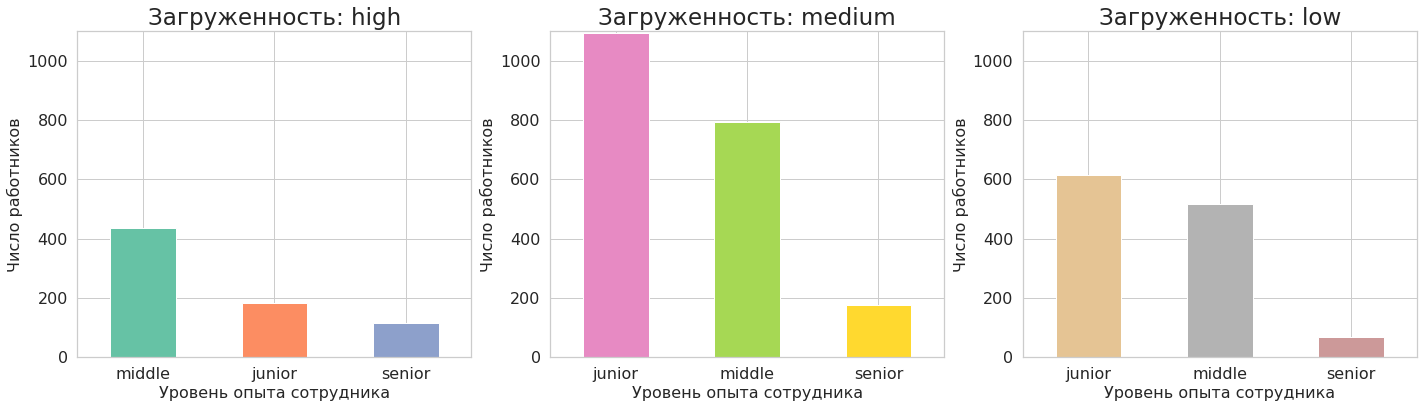

In [ ]:
# смотрим на уровень загруженности
fig, axes = plt.subplots(1,3, figsize=(24,6))

# вызываем снова список цветов, т.к. прыдыдущий с помощью palette[2:] мы исчерпали и отрезали значения
palette = palette_return()

# перебираем по уровню загруженности
for i, work in enumerate(['high', 'medium', 'low']):
    # отбираем сотрудников по степени загруженности и опыту
    x_series = train_job_satisfaction.query("workload==@work")["level"].value_counts()

    # параметры гистограммы
    x_series.plot(kind='bar',
                  color=[palette[i], palette[i+1], palette[i+2]],
                  ax=axes[i])

    axes[i].set_ylim([0,1100])
    axes[i].tick_params("x", rotation=0)
    axes[i].set_title(f'Загруженность: {work}', size=23)
    axes[i].set_xlabel('Уровень опыта сотрудника', size=16)
    axes[i].set_ylabel('Число работников', size=16)
    axes[i].tick_params(labelsize=16)
    # "двигаем" цвета, что графики по разному окрасились
    palette = palette[2:]

Теперь определим уровень удовлетворенности сотрудников с разной загруженностью. Для этого выберем подходящий для деления на две группы порог с помощью графиков.

Объединим тестовые таблицы с информацией об увольнении и удовлетворенности сотрудников.

In [ ]:
# объединяем тестовые данные
df_full = test_target_satisfaction.merge(test_target_quit, on='id')

# смотрим результат, размереность и кол-во пропусков
display(df_full.head(),
        df_full.shape,
        df_full.isna().sum().sum())

,id,job_satisfaction_rate,quit
0,130604,0.74,no
1,825977,0.75,no
2,418490,0.60,yes
3,555320,0.72,no
4,826430,0.08,yes


(2000, 3)

0

Text(0.5, 0, 'Степень удовлетворенности сотрудника')

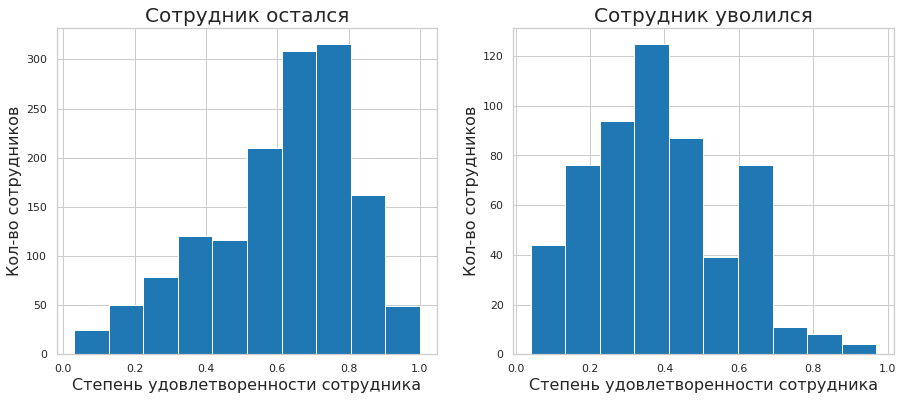

In [ ]:
# строи две гистограммы и отделяем сотрудников, которые ушли и остались
fig, axes = plt.subplots(1,2, figsize=(15,6))

df_full.query('quit=="no"')['job_satisfaction_rate'].hist(ax=axes[0])
axes[0].set_title('Сотрудник остался', size=20)
axes[0].set_ylabel('Кол-во сотрудников', size=16)
axes[0].set_xlabel('Степень удовлетворенности сотрудника', size=16)

df_full.query('quit=="yes"')['job_satisfaction_rate'].hist(ax=axes[1])
axes[1].set_title('Сотрудник уволился', size=20)
axes[1].set_ylabel('Кол-во сотрудников', size=16)
axes[1].set_xlabel('Степень удовлетворенности сотрудника', size=16)

На графиках видим, что большинство сотрудников увольняются, когда уровень их удовлетворенности составляет менее 50% (0.5). На втором графике видно, что даже при уровне удовлетворенности в 70% (0.7) происходят увольнения. Таких данных всего около 80. Если же посмотреть на первый график, где отображены оставшиеся работники, то можно заметить, что более 300 человек с таким же значением удовлетворенности работой осталось, т.е., грубо говоря, их большее число. Поэтому принимаем за основу порог в 50%, где большая вероятнось, что сотрудник уйдет.

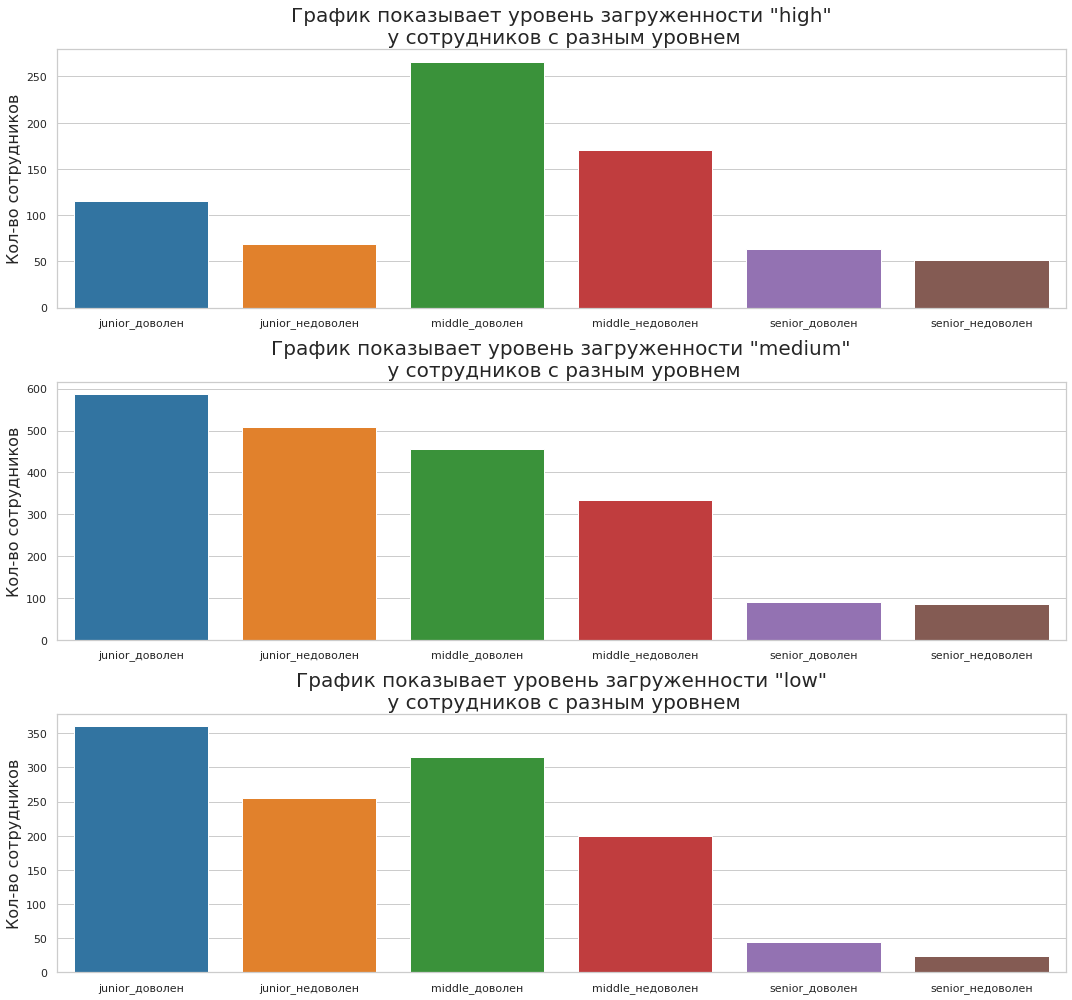

In [ ]:
fig, axes = plt.subplots(3,1, figsize=(15,14))
# проходимся по степени загруженности
for i, work in enumerate(['high', 'medium', 'low']):

    # объявляем и обновляем датафрейм, в котором за одну итерацию будет хранится информация о довольствие сотрудников разного
    # уровня. Например, два столбца: 'junior_доволен': 165 сотрудников и 'junior_недоволен': 45 работников
    df = pd.DataFrame(index=['доволен', 'недоволен'])

    # проходимся по опыту сотрудника
    for j, experience in enumerate(['junior', 'middle', 'senior']):

        # подсчет довольных работников
        df[experience + '_доволен'] = train_job_satisfaction.query('workload==@work and level==@experience\
                                      and job_satisfaction_rate >= 0.5') \
                                      ['job_satisfaction_rate'].apply(lambda x: 'не доволен' if x<0.5 else 'доволен').count()

        # подсчет недовольных работников
        df[experience + '_недоволен'] = train_job_satisfaction.query('workload==@work and level==@experience\
                                        and job_satisfaction_rate < 0.5')['job_satisfaction_rate']\
                                        .apply(lambda x: 'не доволен' if x<0.5 else 'доволен').count()

    sns.barplot(data=df, ax=axes[i])
    axes[i].set_title(f'График показывает уровень загруженности "{work}"\n у сотрудников с разным уровнем',size=20)
    axes[i].set_ylabel('Кол-во сотрудников', size=16)

plt.tight_layout();

**Наблюдения:**

* Графики работы в целом стабильны, и нет явной зависимости между профессиональным уровнем сотрудников и их загруженностью.


* Тем не менее, есть заметная тенденция к высокой загруженности среди сотрудников с меньшим опытом работы (junior, категории medium). Необходимо провести анализ, чтобы выявить, сотрудники с каким опытом чаще всего увольняются.


### 1.6 Соотношение уволившихся и оставшихся сотрудников

Посмотрим, сколько сотрудников покинуло компанию в течение года и какой у них был опыт работы.

In [ ]:
# спискок заголовков для отображения столбца распределения
title_names = ['Отдел работы уволившихся сотрудников', 'Уровень опыта уволившихся сотрудников',
               'Загруженность уволившихся сотрудников', 'Количество лет, проработанных в компании уволившимися сотрудниками',
               'Было ли повышение за год у уволившихся сотрудников', 'Было ли нарушение у уволившихся сотрудников',
               'Оценка работы уволившегося сотрудника руководителем']

# сколько ушло из компании сотрудников (в цикл не входит, поэтому заранее отображаем)
print('Всего ушло сотрудников: ', train_quit.query('quit=="yes"')['id'].count(), 'из',
      train_quit.query('quit=="no"')['id'].count())

# проходимся по всем столбцам train_quit, кроме salary и id
for i,column in enumerate(train_quit.iloc[:, 1:8]):
    # высчитываем значения
    values = train_quit.query('quit=="yes"')[column].value_counts(normalize=True)

    # отображаем
    print(f'{"_"*70}\n{title_names[i]}:\n', values)



Всего ушло сотрудников:  1128 из 2872
______________________________________________________________________
Отдел работы уволившихся сотрудников:
 sales         0.360816
technology    0.244681
purchasing    0.147163
marketing     0.144504
hr            0.102837
Name: dept, dtype: float64
______________________________________________________________________
Уровень опыта уволившихся сотрудников:
 junior    0.889184
middle    0.095745
senior    0.015071
Name: level, dtype: float64
______________________________________________________________________
Загруженность уволившихся сотрудников:
 low       0.460106
medium    0.432624
high      0.107270
Name: workload, dtype: float64
______________________________________________________________________
Количество лет, проработанных в компании уволившимися сотрудниками:
 1     0.531028
2     0.257092
3     0.144504
4     0.023936
5     0.020390
6     0.008865
7     0.006206
8     0.002660
9     0.002660
10    0.002660
Name: employment_years, d

Больше всего из компании уволилось сотрудников с опытом работы на начальном уровне, то есть новичков (junior). Это можно объяснить тем, что для них это был первый опыт работы, и они только набирались опыта. Возможно, через некоторое время они поняли, что направление компании не соответствует их интересам, и решили искать работу в другом месте.

Или, если обратить внимание на предыдущие графики, можно увидеть, что нагрузка на младших сотрудников довольно велика, и это могло вызвать стресс у новичков, что они решили уволиться.

Давайте проанализируем, как уровень удовлетворенности влияет на вероятность ухода сотрудника из компании. Применим t-тест, предварительно разделив таблицу на две категории: в первую войдут сотрудники, которые уволились, а во вторую — те, кто остался. Так же, посмотрим на теже данные с помощью визуализации.

In [ ]:
# разделяем на две группы: сотрудники уволились и остались
quit_yes = df_full.query('quit == "yes"')
quit_no = df_full.query('quit == "no"')

Теперь, чтобы применить t-тест, нам нужно сформулировать нулевую и альтернативную гипотезы, которые будут служить основой для наших выводов.

<b>Гипотезы:</b>
* <b>H0</b> - среднее значение удовлетворенности оставшихся в компании сотрудников не выше, чем у уволившихся.
* <b>H1</b> - среднее значение удовлетворенности оставшихся в компании сотрудников выше, чем у уволившихся.

In [ ]:
# Уровень статистической значимости
alpha = 0.05

# Проверяем гипотезу
result = st.ttest_ind(quit_no['job_satisfaction_rate'], quit_yes['job_satisfaction_rate'],
                      alternative='greater')

print('Среднее выборки quit_no:', quit_no['job_satisfaction_rate'].mean())
print('Среднее выборки quit_yes:', quit_yes['job_satisfaction_rate'].mean())
print(f'p-значение: {result.pvalue}')

# проверяем будет ли гипотеза отвергнута
('Отвергаем H0') if result.pvalue < alpha else ('Не отвергаем')

Среднее выборки quit_no: 0.6120403899721449
Среднее выборки quit_yes: 0.38771276595744686
p-значение: 6.155610332585965e-105


'Отвергаем H0'



Нулевую гипотезу мы отвергаем. Есть основания полагать, что удовлетворенность сотрудника работой напрямую влияет на его решение остаться в компании или уйти.

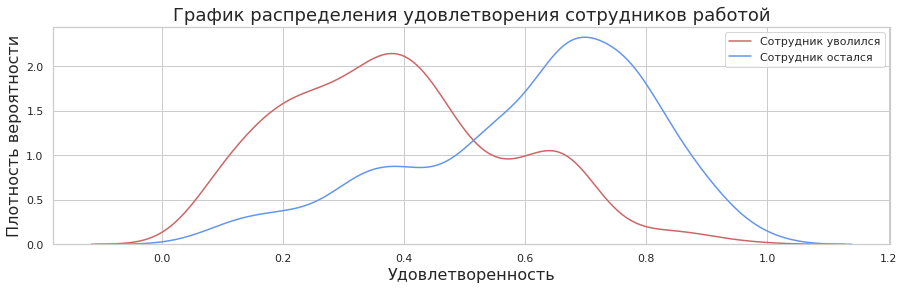

In [ ]:
fig, ax = plt.subplots(figsize=(15,4))
sns.kdeplot(x=quit_yes['job_satisfaction_rate'], color='#CC6666', label='Сотрудник уволился')
sns.kdeplot(x=quit_no['job_satisfaction_rate'], color='cornflowerblue', label='Сотрудник остался');

plt.title('График распределения удовлетворения сотрудников работой', size=18)
plt.xlabel('Удовлетворенность', size=16)
plt.ylabel('Плотность вероятности', size=16)
plt.legend();

**Наблюдение:**

* Существует явная взаимосвязь между увольнением сотрудника и его уровнем удовлетворенности. Чем ниже уровень удовлетворенности, тем больше вероятность потери сотрудника.

* Лишь небольшое количество людей, удовлетворенных своей работой более чем на 70%, уходят из компании. Возможно, это связано с тем, что они находят для себя более привлекательную работу, учитывая условия труда и уровень оплаты.

Сравним среднюю заработную плату ушедших и оставшихся сотрудников. В качестве основы для сравнения выберем категориальный признак — уровень опыта сотрудника (level). Берем этот критерий, так как при найме на работу размер заработной платы напрямую зависит от уровня работника.

In [ ]:
# проходимся по опыту работников
for i, experience in enumerate(['junior', 'middle', 'senior']):
    salary_mean_quit_no = round(train_quit.query('quit=="no" and level==@experience')['salary'].mean(), 0)
    salary_mean_quit_yes = round(train_quit.query('quit=="yes" and level==@experience')['salary'].mean(), 0)

    print(f'{"_"*70}\nСотрудник уровня {experience} уволился: {salary_mean_quit_yes} среднее значение зарплаты')
    print(f'Сотрудник уровня {experience} остался: {salary_mean_quit_no} среднее значение зарплаты')
    print(f'Разница: {salary_mean_quit_no - salary_mean_quit_yes} руб.')

______________________________________________________________________
Сотрудник уровня junior уволился: 22508.0 среднее значение зарплаты
Сотрудник уровня junior остался: 25662.0 среднее значение зарплаты
Разница: 3154.0 руб.
______________________________________________________________________
Сотрудник уровня middle уволился: 33122.0 среднее значение зарплаты
Сотрудник уровня middle остался: 40076.0 среднее значение зарплаты
Разница: 6954.0 руб.
______________________________________________________________________
Сотрудник уровня senior уволился: 46447.0 среднее значение зарплаты
Сотрудник уровня senior остался: 60131.0 среднее значение зарплаты
Разница: 13684.0 руб.


**Наблюдение:**

* Разница в размере средней заработной платы для специалистов с разным опытом работы не является слишком большой.

### 1.7 Корреляционный анализ

**Задача.** Провести корреляционный анализ признаков в таблицах train_job_satisfaction и train_quit.

Сперва посмотрим взаимосвязь между признаками таблицы train_job_satisfaction.

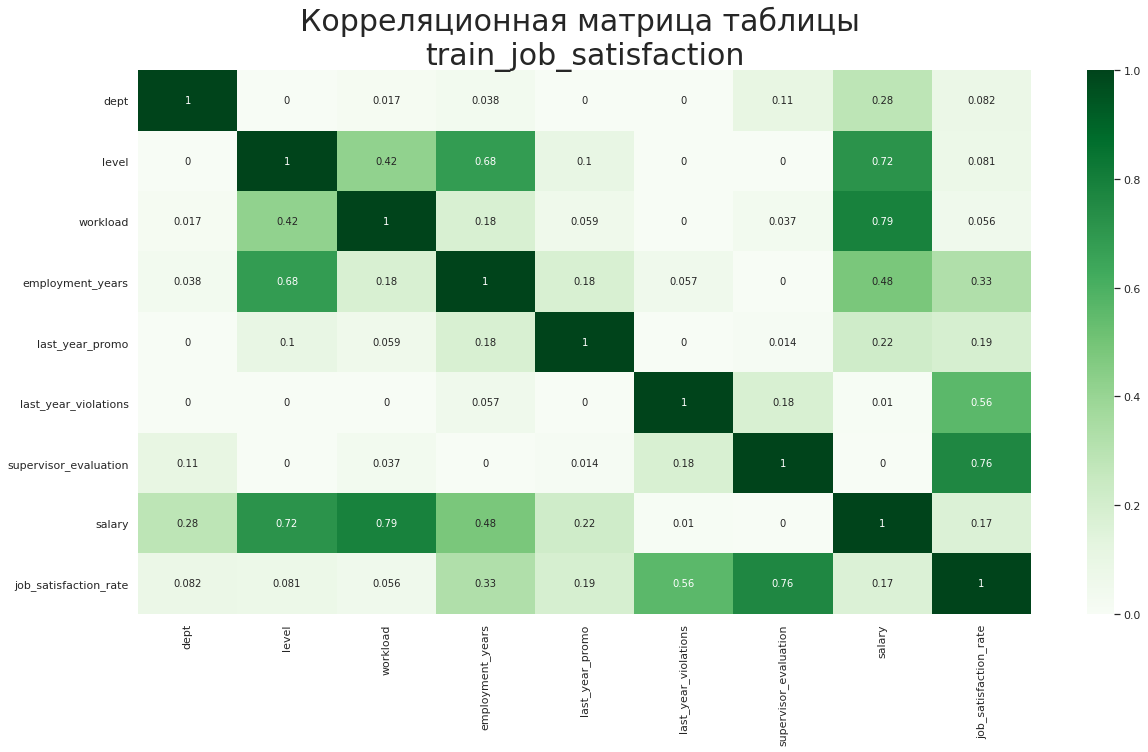

In [ ]:
fig = plt.subplots(figsize=(20,10))

# строим матрицу корреляции
(
    sns.heatmap(train_job_satisfaction.drop(columns=['id']) \
                              .phik_matrix(interval_cols=list(train_job_satisfaction.select_dtypes(include='number'))[3:]),
                                           annot=True, cmap='Greens')
)

plt.title('Корреляционная матрица таблицы \ntrain_job_satisfaction', size=30);

Мы определили job_satisfaction_rate (уровень удовлетворённости сотрудника) как целевой признак. Теперь нам нужно проанализировать, как он связан с другими, так называемыми входными, признаками.

<b>Лучше всего коррелирует с:</b>
* supervisor_evaluation (Оценка руководителя о работе сотрудника) - корреляция 76%.

<b>Умеренная корреляция с:</b>
* last_year_violations (нарушал ли трудовой договор) - корреляция 56%.

<b>Слабая корреляция с:</b>
* employment_years (кол-во лет в компании) - 33%.
* last_year_promo (было ли повышение за год) - 19%.
* salary (зарплата) - 17%.
* dept (отдел сотрудника) - 8.2%.
* level (опыт сотрудника) - 8.1%.
* workload (загруженность) - 5.6%.

**Другие наблюдения:**

* Признак level, отражающий опыт сотрудника, тесно связан с другими входными данными, такими как зарплата, стаж работы в компании и уровень загруженности. В большинстве случаев, чем больше опыт, тем значительнее изменения в этих показателях.

* Соблюдение сотрудником условий трудового договора напрямую связано с его уровнем удовлетворённости.

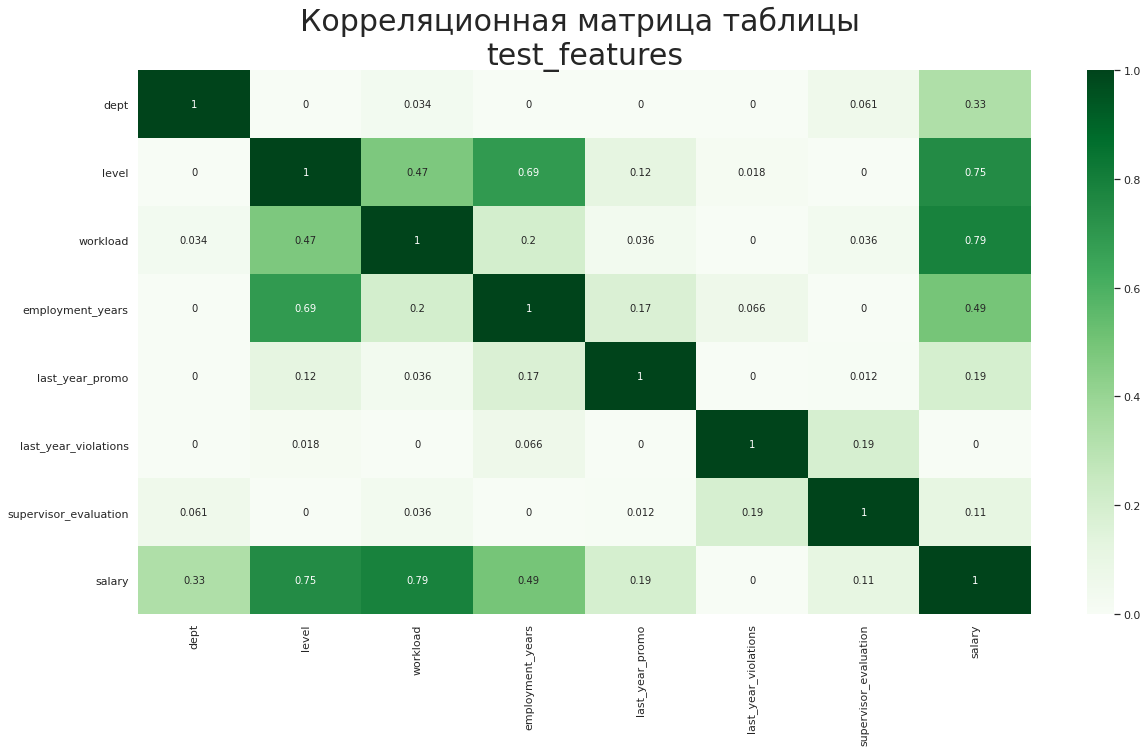

In [ ]:
fig = plt.subplots(figsize=(20,10))

# строим матрицу корреляции
(
    sns.heatmap(test_features.drop(columns=['id']) \
                              .phik_matrix(interval_cols=list(test_features.select_dtypes(include='number'))[1:]),
                                           annot=True, cmap='Greens')
)

plt.title('Корреляционная матрица таблицы \ntest_features', size=30);

Так как у test_features отсуствуют данные о целевых признаках, рассмотрим корреляцию входных между собой.

<b>Признак salary (зарплата) лучше всего коррелирует с:</b>

* workload (загруженность) - 79%.
* level (опыт сотрудника) - 75%.


<b>Признак level (уровень опыта сотрудника) лучше всего коррелирует с:</b>

* salary (зарплата) - 75%.
* employment_years (кол-во лет в компании) - 69%.


<b>Признак workload (загруженность) лучше всего коррелирует с:</b>

* workload (загруженность) - 79%.
* level (опыт сотрудника) - 47%.

<b>Признак employment_years (кол-во лет в компании) лучше всего коррелирует с:</b>

* level (опыт сотрудника) - 69%.
* salary (зарплата) - 49%.

<b>------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------</b>


<b>Вывод блока (Исследовательский анализ данных):</b>

* Изучили распределение категориальных данных;
* Исследования показали, что удовлетворенность сотрудников во многом определяет их решение покинуть компанию в будущем;
* Построили две матрицы корреляции и оценили, насколько сильно связаны входные признаки с целевыми.

<b>------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------</b>

## Подготовка данных 1

**Задача.** Подготовить данные для обучения модели, которая будет предсказывать удовлетворенность сотрудника.

In [ ]:
# столбец id убираем в индекс
train_job_satisfaction = train_job_satisfaction.set_index('id')

# y_test
test_target_satisfaction = test_target_satisfaction.set_index('id')
# X_test
test_features = test_features.set_index('id')

# проверяем
display(train_job_satisfaction.head(),
        test_target_satisfaction.head(),
        test_features.head())

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
id,,,,,,,,,
155278,sales,junior,medium,2,no,no,1,24000,0.58
653870,hr,junior,high,2,no,no,5,38400,0.76
184592,sales,junior,low,1,no,no,2,12000,0.11
171431,technology,junior,low,4,no,no,2,18000,0.37
693419,hr,junior,medium,1,no,no,3,22800,0.20


,job_satisfaction_rate
id,
130604,0.74
825977,0.75
418490,0.60
555320,0.72
826430,0.08


,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
id,,,,,,,,
485046,marketing,junior,medium,2,no,no,5,28800
686555,hr,junior,medium,1,no,no,4,30000
467458,sales,middle,low,5,no,no,4,19200
418655,sales,middle,low,6,no,no,4,19200
789145,hr,middle,medium,5,no,no,5,40800


In [ ]:
# проверяем на появление дубликатов в train_job_satisfaction
print('Кол-во дубликатов в train_job_satisfaction: ',train_job_satisfaction.duplicated().sum())


Кол-во дубликатов в train_job_satisfaction:  245


In [ ]:
# устраняем дубликаты
train_job_satisfaction = train_job_satisfaction.drop_duplicates()
print('Кол-во дубликатов в train_job_satisfaction: ',train_job_satisfaction.duplicated().sum())

Кол-во дубликатов в train_job_satisfaction:  0


In [ ]:
# после удаления строк сортируем индексы
train_job_satisfaction = train_job_satisfaction.sort_index()

In [ ]:
RANDOM_STATE = 42

# сохраняем целевой и входные признаки
X = train_job_satisfaction.drop(columns=['job_satisfaction_rate'], axis = 1)
y = train_job_satisfaction['job_satisfaction_rate']

In [ ]:
# создаем списки с названиями признаков
ohe_columns = ['dept', 'last_year_promo', 'last_year_violations']
ord_columns = ['level', 'workload']
num_columns = ['employment_years', 'supervisor_evaluation', 'salary']


In [ ]:
# создаём пайплайн для подготовки признаков из списка ohe_columns

ohe_pipe = Pipeline(
    [
        ('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
        ('ohe', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'))
    ]
)


In [ ]:
# создаём пайплайн для подготовки признаков из списка ord_columns
ord_pipe = Pipeline(
    [
        (
            'simpleImputer_ord_before',
            SimpleImputer(strategy='most_frequent')
        ),
        (
            'ord',
            OrdinalEncoder(
                categories=[
                    ['junior', 'middle', 'sinior'],
                    ['low', 'medium', 'high']
                ],
                handle_unknown='use_encoded_value', unknown_value=np.nan)
        ),

        (
            'simpleImputer_after_ord',
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        )
    ]
)



In [ ]:
# создаём общий пайплайн для подготовки данных
data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns),
     ('ord', ord_pipe, ord_columns),
     ('num', MinMaxScaler(), num_columns)
    ],
    remainder='passthrough'
)


In [ ]:
# создаём итоговый пайплайн: подготовка данных и модель
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', LinearRegression(n_jobs=-1))
])


<b>------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------</b>


**Итог блока (Подготовка данных 1):**

* В этом блоке данные были разделены на выборки, и создан пайплайн (конвейр) для подготовки модели к обучению.

<b>------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------</b>


## Обучение модели 1

**Задача.** Обучить несколько моделей предсказывать удовлетворенность сотрудников, отобрать лучшую.

Для начала создадим функцию, которая будет вычислять метрику SMAPE. Эта метрика поможет нам оценить качество модели и выбрать лучшую из них.

In [ ]:
# создаем функция Smape
def smape_score(y_true, y_pred):
    return 100/len(y_true) * np.sum(np.abs(y_true-y_pred)/((np.abs(y_true) + np.abs(y_pred))/2))


In [ ]:
# создаем scorer для Smape
smape_scorer = make_scorer(smape_score, greater_is_better=False)

In [ ]:
# подбор гиперпараметров

param_grid = [
    # словарь для модели KNeighborsRegressor()
    {
        'models': [KNeighborsRegressor()],
        'models__n_neighbors': range(3, 10),
        'models__weights': ['uniform', 'distance'],
        'models__algorithm': ['auto', 'brute'],
        'models__p': [1, 2],
        'models__metric': ['euclidean', 'manhattan'],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']
    },

    # словарь для модели DecisionTreeRegressor()
    {
        'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 10),
        'models__max_features': range(2, 10),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']
    },

        # словарь для модели LinearRegression()
    {
        'models' : [LinearRegression(n_jobs=-1)],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    }

]

In [ ]:
# автоматизация подбора гиперпараметров
randomized_search = RandomizedSearchCV(
    pipe_final,
    param_grid,
    cv=5,
    scoring=smape_scorer,
    random_state=RANDOM_STATE,
    n_jobs=-1
)

In [ ]:
# обучаем модель
randomized_search.fit(X, y)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ohe',
                                                                               Pipeline(steps=[('simpleImputer_ohe',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('ohe',
                                                                                                OneHotEncoder(drop='first',
                                                                                                              handle_unknown='ignore',
                                                                                                              sparse_output=False))]),
                                                                               ['dept',
                                                                                'last_year_promo',
                                                                                'last_year_violations']),
                                                                              ('ord',
                                                                               Pip...
                                         'models__max_depth': range(2, 10),
                                         'models__max_features': range(2, 10),
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               RobustScaler(),
                                                               'passthrough']},
                                        {'models': [LinearRegression(n_jobs=-1)],
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               'passthrough']}],
                   random_state=42,
                   scoring=make_scorer(smape_score, greater_is_better=False, response_method='predict'))

In [ ]:
# Смотрим лучшие параметры модели
print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['dept', 'last_year_promo',
                                                   'last_year_violations']),
                                                 ('ord',
                            

In [ ]:
# смотрим метрику SMAPE
print('Метрика лучшей модели по кросс-валидации на обучающих данных:', randomized_search.best_score_*-1)

Метрика лучшей модели по кросс-валидации на обучающих данных: 16.36646593380148


In [ ]:
# сортируем наши, условно назовем, y_test и X_test по индексу, чтобы все правильно, построчно вычислялось и работало, когда
# применим  метрику SMAPE
test_target_satisfaction = test_target_satisfaction.sort_index()
test_features = test_features.sort_index()

display(test_target_satisfaction.head(), test_features.head())

,job_satisfaction_rate
id,
100298,0.80
100480,0.84
100503,0.79
100610,0.75
100692,0.69


,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
id,,,,,,,,
100298,hr,junior,low,2,no,no,4,19200
100480,marketing,junior,low,4,no,no,4,16800
100503,purchasing,middle,high,5,no,no,4,55200
100610,sales,middle,medium,5,no,no,4,43200
100692,sales,middle,high,6,no,no,4,48000


In [ ]:
# прогнозируем значения
y_pred = randomized_search.predict(test_features)

In [ ]:
# выводим метрику SMAPE
smape_score(test_target_satisfaction['job_satisfaction_rate'], y_pred)

14.25152399898245

Согласно техническому заданию, значение метрики SMAPE не должно превышать 15: *(SMAPE ≤ 15)*. Наша модель, основываясь на предсказанных данных, рассчитала значение, равное 14,3. Это означает, что условие выполнено, и на данном этапе мы достигли успеха.

### Проверка модели на адекватность

**Задача.** Сравнить качество работы модели с качеством ее предсказаний.

In [ ]:
# создаем экземпляр DummyRegressor
dummy_model = DummyRegressor()

In [ ]:
# обучаем DummyRegressor на тренировочных данных
dummy_model.fit(X, y)

DummyRegressor()

In [ ]:
# прогнозируем значения на тестовых данных
dummy_model_preds = dummy_model.predict(test_features)

In [ ]:
# рассчитываем метрику SMAPE
print(f'Метрика SMAPE dummy: {smape_score(test_target_satisfaction["job_satisfaction_rate"], dummy_model_preds)}')
print(f'Метрика SMAPE на тестовой выборке: {smape_score(test_target_satisfaction["job_satisfaction_rate"], y_pred)}')

Метрика SMAPE dummy: 38.26225790202238
Метрика SMAPE на тестовой выборке: 14.25152399898245


Выбранная нами метрика, значение которой составляет 14.25, значительно превосходит базовый подход к прогнозированию (38.26). Это говорит о том, что модель адекватна и более эффективна.

<b>------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------</b>


<b>Вывод блока (Обучение модели 1):</b>

* Были обучены несколько моделей, которые прогнозируют удовлетворённость сотрудников своей работой. Затем была выбрана лучшая модель, с учитом ее параметров.
* Создана функция с метрикой, которая позволяет оценить качество работы модели — SMAPE.
* Успешно выполнили техническое задание, которое требовало, чтобы показатель SMAPE не превышал 15. Лучшая из предложенных моделей достигла значения 14,3 (14,25).
* Модель была проверена на адекватность предсказаний.

<b>------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------</b>

In [ ]:
# добавлям новый признак
train_quit['job_satisfaction_rate'] = randomized_search.best_estimator_.predict(train_quit)

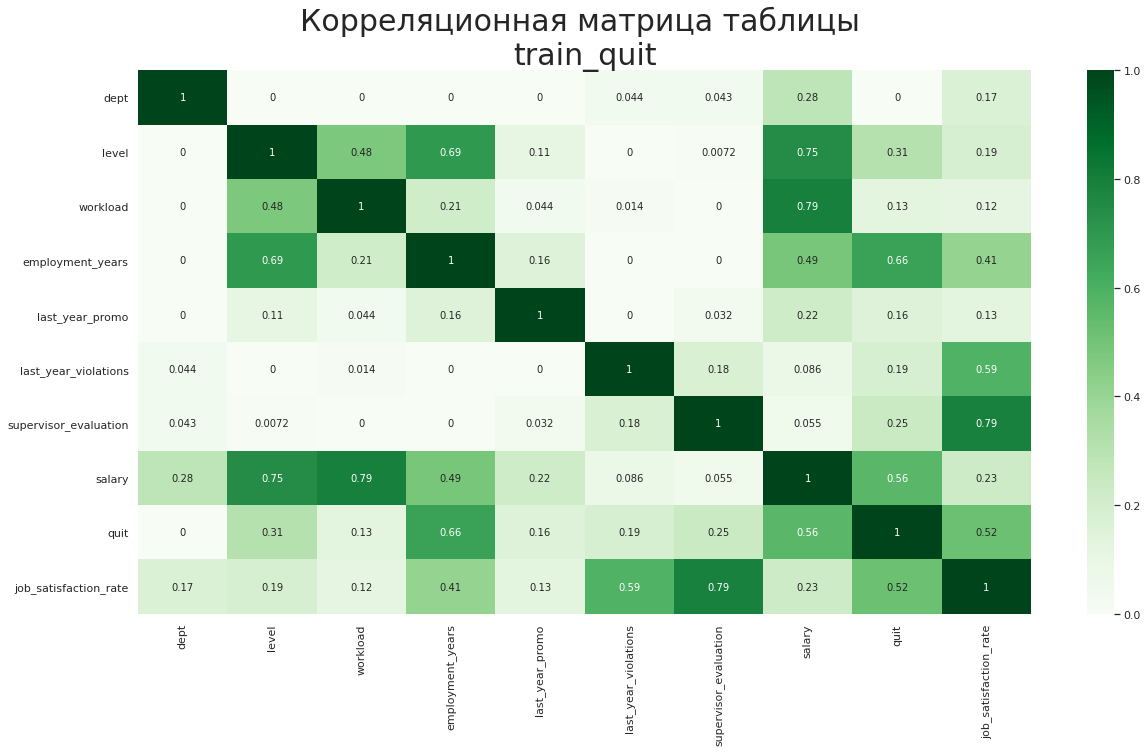

In [ ]:
fig = plt.subplots(figsize=(20,10))

# строим матрицу корреляции
(
    sns.heatmap(train_quit.drop(columns=['id']) \
                              .phik_matrix(interval_cols=list(train_job_satisfaction.select_dtypes(include='number'))[2:]),
                                           annot=True, cmap='Greens')
)

plt.title('Корреляционная матрица таблицы \ntrain_quit', size=30);

Тут целевым признаком является уволился ли сотрудник (quit).

<b>Лучше всего коррелирует с:</b>
* employment_years (кол-во лет в компании) - 66%.
* salary (зарплата) - 60%.

<b>Умеренная корреляция с:</b>

* job_satisfaction_rate (удоветворенность сотрудника) - 52%.
* level (опыт сотрудника) - 31%.

<b>Слабая корреляция с:</b>
* supervisor_evaluation (Оценка руководителя о работе сотрудника) - корреляция 25%.
* last_year_violations (нарушал ли трудовой договор) - корреляция 19%.
* last_year_promo (было ли повышение за год) - 16%.
* workload (загруженность) - 13%.


<b>Корреляция отсуствует с:</b>

* dept (отдел сотрудника) - 0%.

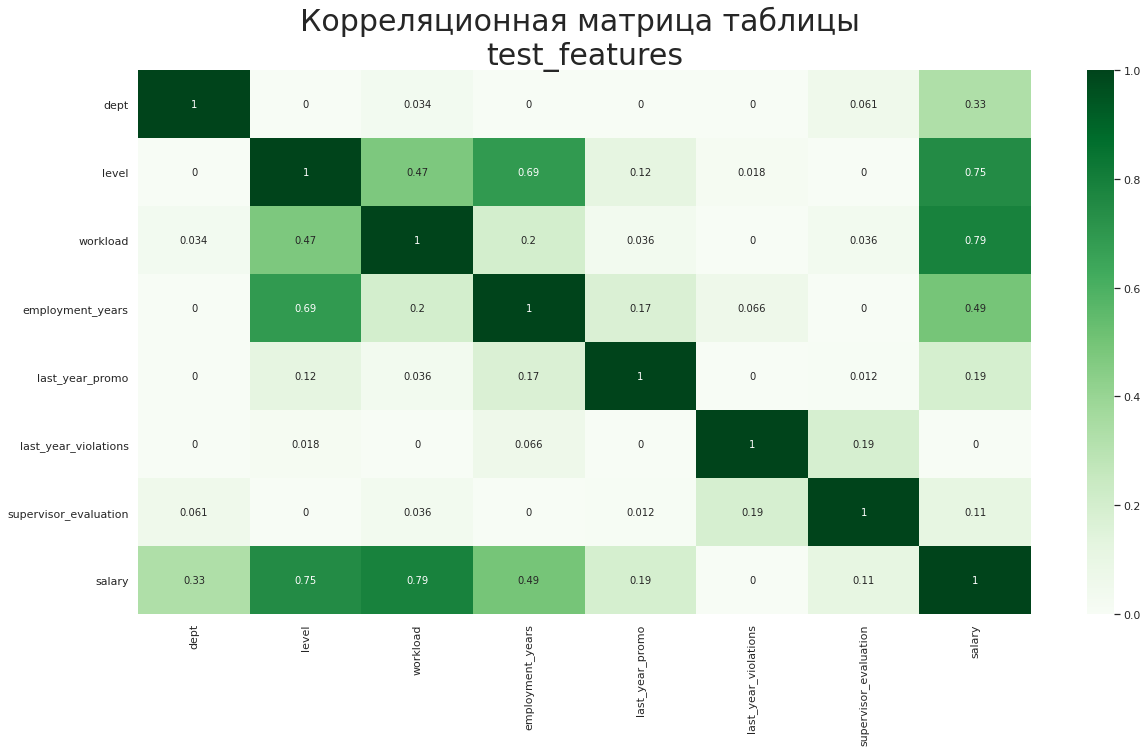

In [ ]:
fig = plt.subplots(figsize=(20,10))

# строим матрицу корреляции
(
    sns.heatmap(test_features \
                              .phik_matrix(interval_cols=list(test_features.select_dtypes(include='number'))[2:]),
                                           annot=True, cmap='Greens')
)

plt.title('Корреляционная матрица таблицы \ntest_features', size=30);

В таблице test_features сохраняется та же корреляция между входными признаками, что и в прошлый раз.


<b>------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------</b>


<b>Вывод блока (Корреляционный анализ 2):</b>

* Были сделаны две корреляционные матрицы.
* Орентируясь на матрицу таблицы train_quit, были выявлены признаки с разной степенью корреляции.
* Признаки, которые сильно коррелируют с целевым показателем: employment_years (кол-во лет в компании), salary (зарплата).
* Корреляция между входными признаками таблицы test_features осталась прежней.

<b>------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------</b>

## Подготовка данных 2

**Задача.** Подготовить данные для обучения моделей, которые смогут предсказать увольнение сотрудника.

### 1.1 Добавление нового  признака

**Задача.** Добавить к таблице *train_quit* новый признак job_satisfaction_rate (удовлетворенность работой), для повышения точности предсказания модели.

In [ ]:
# столбец id, убираем в индекс
train_quit = train_quit.set_index('id')
test_target_quit = test_target_quit.set_index('id')
display(train_quit.head(), test_target_quit.head())

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit,job_satisfaction_rate
id,,,,,,,,,,
723290,sales,middle,high,2,no,no,4,54000,no,0.570593
814010,sales,junior,medium,2,no,no,4,27600,no,0.826667
155091,purchasing,middle,medium,5,no,no,1,37200,no,0.328510
257132,sales,junior,medium,2,no,yes,3,24000,yes,0.380000
910140,marketing,junior,medium,2,no,no,5,25200,no,0.690000


,quit
id,
999029,yes
372846,no
726767,no
490105,no
416898,yes


In [ ]:
# кодируем целевой признак quit
le = LabelEncoder()
train_quit['quit'] = le.fit_transform(train_quit['quit'])
test_target_quit['quit'] = le.fit_transform(test_target_quit['quit'])

# проверяем
display(train_quit['quit'].head(), test_target_quit['quit'].head())

id
723290    0
814010    0
155091    0
257132    1
910140    0
Name: quit, dtype: int64

id
999029    1
372846    0
726767    0
490105    0
416898    1
Name: quit, dtype: int64

In [ ]:
# смотрим правильный ли порядок классов
le.classes_

array(['no', 'yes'], dtype=object)

In [ ]:
# объявляем X_train, у выборки удаляем целевой признак quit
X_train_quit = train_quit.drop(['quit'], axis=1).copy()
# объявляем y_train
y_train_quit = train_quit['quit']


# добавляем новый столбцец с предсказанной удовлетворенностью сотрудника
X_train_quit['job_satisfaction_rate'] = randomized_search.best_estimator_.predict(X_train_quit)
test_features['job_satisfaction_rate'] = randomized_search.best_estimator_.predict(test_features)

# проверяем
display(X_train_quit.head(), test_features.head(), y_train_quit.head())

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
id,,,,,,,,,
723290,sales,middle,high,2,no,no,4,54000,0.570593
814010,sales,junior,medium,2,no,no,4,27600,0.826667
155091,purchasing,middle,medium,5,no,no,1,37200,0.328510
257132,sales,junior,medium,2,no,yes,3,24000,0.380000
910140,marketing,junior,medium,2,no,no,5,25200,0.690000


,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
id,,,,,,,,,
100298,hr,junior,low,2,no,no,4,19200,0.820000
100480,marketing,junior,low,4,no,no,4,16800,0.831129
100503,purchasing,middle,high,5,no,no,4,55200,0.709812
100610,sales,middle,medium,5,no,no,4,43200,0.814000
100692,sales,middle,high,6,no,no,4,48000,0.703333


id
723290    0
814010    0
155091    0
257132    1
910140    0
Name: quit, dtype: int64

In [ ]:
# добавляем новый столбцец с предсказанной удовлетворенностью сотрудника
X_train_quit['job_satisfaction_rate'] = randomized_search.best_estimator_.predict(X_train_quit)
test_features['job_satisfaction_rate'] = randomized_search.best_estimator_.predict(test_features)

# проверяем
display(X_train_quit.head(), test_features.head(), y_train_quit.head())

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
id,,,,,,,,,
723290,sales,middle,high,2,no,no,4,54000,0.570593
814010,sales,junior,medium,2,no,no,4,27600,0.826667
155091,purchasing,middle,medium,5,no,no,1,37200,0.328510
257132,sales,junior,medium,2,no,yes,3,24000,0.380000
910140,marketing,junior,medium,2,no,no,5,25200,0.690000


,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
id,,,,,,,,,
100298,hr,junior,low,2,no,no,4,19200,0.820000
100480,marketing,junior,low,4,no,no,4,16800,0.831129
100503,purchasing,middle,high,5,no,no,4,55200,0.709812
100610,sales,middle,medium,5,no,no,4,43200,0.814000
100692,sales,middle,high,6,no,no,4,48000,0.703333


id
723290    0
814010    0
155091    0
257132    1
910140    0
Name: quit, dtype: int64

## Обучение модели 2

**Задача.** Обучаем модели предсказывать увольнение сотрудника.

In [ ]:
# в список добавляем признак job_satisfaction_rate
num_columns = ['employment_years', 'supervisor_evaluation', 'salary', 'job_satisfaction_rate']

In [ ]:
# создаём итоговый пайплайн: подготовка данных и модель
pipe_final_2 = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', LogisticRegression(random_state=RANDOM_STATE))

])

In [ ]:
# подбор гиперпараметров
param_grid_2 = [
    # словарь для модели KNeighborsClassifier()
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(1, 20),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler()]
    },

    # словарь для модели DecisionTreeClassifier()
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 10),
        'models__max_features': range(2, 10),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']
    },

    # словарь для модели SVC()
    {
        'models': [SVC(random_state=RANDOM_STATE, probability= True)],
        'models__C': range(1, 10),
        'models__kernel': ['rbf', 'linear', 'sigmoid'],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']

    },

    # словарь для модели LogisticRegression()
    {
        'models': [LogisticRegression(random_state=RANDOM_STATE, solver='liblinear', penalty='l1')],
        'models__C': range(1, 10),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    }

]

In [ ]:
# автоматизация подбора гиперпараметров
randomized_search_2 = RandomizedSearchCV(
    pipe_final_2,
    param_grid_2,
    cv=5,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1
)

In [ ]:
# обучение модели
randomized_search_2.fit(X_train_quit, y_train_quit)

/opt/conda/lib/python3.9/site-packages/sklearn/compose/_column_transformer.py:1667: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ohe',
                                                                               Pipeline(steps=[('simpleImputer_ohe',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('ohe',
                                                                                                OneHotEncoder(drop='first',
                                                                                                              handle_unknown='ignore',
                                                                                                              sparse_output=False))]),
                                                                               ['dept',
                                                                                'last_year_promo',
                                                                                'last_year_violations']),
                                                                              ('ord',
                                                                               Pip...
                                                        random_state=42)],
                                         'models__C': range(1, 10),
                                         'models__kernel': ['rbf', 'linear',
                                                            'sigmoid'],
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               'passthrough']},
                                        {'models': [LogisticRegression(penalty='l1',
                                                                       random_state=42,
                                                                       solver='liblinear')],
                                         'models__C': range(1, 10),
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               'passthrough']}],
                   random_state=42, scoring='roc_auc')

In [ ]:
# Смотрим лучшие параметры модели
print('Лучшая модель и её параметры:\n\n', randomized_search_2.best_estimator_)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['dept', 'last_year_promo',
                                                   'last_year_violations']),
                                                 ('ord',
                            

In [ ]:
# смотрим лучшую метрику
print ('Метрика лучшей модели на кросс-валидации:', randomized_search_2.best_score_)

Метрика лучшей модели на кросс-валидации: 0.924662195427319


Перед тем как рассчитать метрику ROC-кривой, которая покажет, насколько точно модель делает прогнозы, мы преобразуем столбец id в индекс. После этого мы сортируем индексы в тестовой выборке и целевом признаке, чтобы обеспечить корректный расчет метрики.

In [ ]:
# сортируем индексы
test_target_quit = test_target_quit.sort_index()
test_features = test_features.sort_index()

# проверяем
display(test_target_quit.head(), test_features.head())

,quit
id,
100298,0
100480,0
100503,0
100610,0
100692,0


,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
id,,,,,,,,,
100298,hr,junior,low,2,no,no,4,19200,0.820000
100480,marketing,junior,low,4,no,no,4,16800,0.831129
100503,purchasing,middle,high,5,no,no,4,55200,0.709812
100610,sales,middle,medium,5,no,no,4,43200,0.814000
100692,sales,middle,high,6,no,no,4,48000,0.703333


In [ ]:
# проверяем работу модели на тестовой выборке и делаем прогноз
proba = randomized_search_2.best_estimator_.predict_proba(test_features)
proba_one = proba[:, 1]
print(f'Метрика ROC-кривая на тестовой выборке: {roc_auc_score(test_target_quit, proba_one)}')

Метрика ROC-кривая на тестовой выборке: 0.9130224075939863


В соответствии с техническим заданием, показатель roc-auc должен быть равен или не ниже 0,91. Полученное значение равно 0.91, что соответствует требованиям.

### Проверка модели на адекватность

**Задача.** Сравнить качество работы модели с качеством ее предсказаний.

In [ ]:
# создаем экземпляр DummyClassifier
dummy_model = DummyClassifier()

In [ ]:
# обучаем DummyClassifier на тренировочных данных
dummy_model.fit(X, y)

DummyClassifier()

In [ ]:
# прогнозируем вероятности принадлежности к положительному классу на тестовых данных
dummy_model_preds = dummy_model.predict_proba(test_features)[:, 1]

In [ ]:
print(f'Метрика ROC-кривая dummy: {roc_auc_score(test_target_quit, dummy_model_preds)}')
print(f'Метрика ROC-кривая на тестовой выборке: {roc_auc_score(test_target_quit, proba_one)}')

Метрика ROC-кривая dummy: 0.5
Метрика ROC-кривая на тестовой выборке: 0.9130224075939863


Сравнение демонстрирует, что выбранная модель делает гораздо более точные прогнозы и лучшую работу по сравнению с базовой стратегией прогнозирования. Модель работает эффективно и адекватно.

**Тестовое предсказание модели, на проверочных данных.**

Пример работы модели.

In [ ]:
# посмотрим на предсказания модели
test_features['quit'] = randomized_search_2.best_estimator_.predict(test_features)

test_features.tail(10)

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate,quit
id,,,,,,,,,,
995636,sales,senior,low,7,no,no,3,31200,0.433105,0
995943,sales,middle,medium,3,no,no,4,38400,0.653333,0
996005,sales,middle,low,3,no,no,4,19200,0.466667,0
997195,sales,middle,low,8,no,yes,3,27600,0.304431,0
997233,technology,middle,high,5,no,no,4,57600,0.705252,0
997290,sales,senior,medium,7,no,no,4,58800,0.777830,0
998548,marketing,junior,medium,2,no,no,4,32400,0.790000,0
998762,technology,junior,low,3,no,no,3,22800,0.505000,1
998900,marketing,middle,medium,7,no,no,3,45600,0.439565,0


In [ ]:
# смотрим на распределение увольнения
test_features['quit'].apply(lambda x: 'Сотрудник уволится' if x==1 else 'Сотрудник останется').value_counts()

Сотрудник останется    1456
Сотрудник уволится      544
Name: quit, dtype: int64

In [ ]:
# смотрим на распределение удовлетворения работой
test_features['job_satisfaction_rate'].apply(lambda x: 'Доволен работой' if x>0.5 else 'Не доволен работой').value_counts()

Доволен работой       1220
Не доволен работой     780
Name: job_satisfaction_rate, dtype: int64

<b>------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------</b>


<b>Вывод блока (Обучение модели 2):</b>

* Для прогнозирования ухода сотрудников из компании было разработано несколько моделей, из которых была выбрана лучшая, исходя из определённых критериев.


* Успешно выполнено техническое задание, которое требовало, чтобы метрика roc_auc была ≥ 0.91. Лучшая модель достигла значения 0.91.

<b>------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------</b>

## Итоговые выводы

**Прогноз модели об удовлетворенности работой сотрудников и уходом из компании:**

Для демонстрации работы прогнозных значений были использованы две модели на тестовых данных. Результаты предсказаний показали следующее:

* Из 2000 сотрудников (это общее количество значений в тестовой таблице) останутся работать 1456 человек, а 544 уйдут;
* Если взять пороговое значение 0.5 (50%), то из 2000 тысяч сотрудников будут удовлетворены работой 1220 человек, а недовольны — 780.


<b>--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------</b>

**Реклмендации:**

* Самое важное, без чего не будут работать никакие рекомендации, — это руководство. Если руководитель некомпетентен и имеет скверный характер, то уровень удовлетворённости сотрудников работой будет снижаться, и в результате увеличится текучка кадров. Поэтому так важно проверять руководителя на его способность эффективно взаимодействовать с подчиненными.


* Важно создать на работе комфортную для <u>*души*</u> атмосферу. Независимо от размера заработной платы и ее повышения, если сотрудник постоянно испытывает стресс и находится в плохом настроении, он может рассмотреть возможность смены места работы на более приятное для себя. Например, одна моя знакомая с воодушевлением рассказвала мне, что ни за какие блага не покинет компанию в которой работает, потому что коллеги стали для нее как вторая семья. Внизу постараюсь дать рекомендации о том, как этого возможно достичь.


* Обеденные перерывы по группам из разных отделов. Еще Сергей Королев, советский ученый и конструктор ракетно-космических систем, заметил, что если во время обеденного перерыва разделить сотрудников на группы по разным, совершенно противоположным отделам, например, физиков и математиков, то это может привести к удивительным результатам. В таких беседах, где смешиваются знания из разных областей, часто рождаются новые идеи.

  Королев был настолько впечатлен этим наблюдением, что увеличил обеденный перерыв на целый час. Благодаря такому делению сотрудников на группы, их эффективность значительно возросла.



* Нанять человека, обладающего навыками коммуникатора, способного стать душой коллектива, негласным лидером, умеющим находить общий язык с любым человеком и оказывать поддержку в нужный момент. Этот специалист должен быть также доброжелательным  и любить общение. Его работа будет заключаться в том, чтобы поддерживать связь с коллегами, помнить о днях рождения сотрудников и организовывать в их честь вечеринки. Также он будет стараться подбадривать людей, проходя мимо, и одновременно отслеживать настроение в коллективе. В общем, делать все, чтобы настроение коллектива было прекрасным, а если у сотрудника хорошее настроение, то и эффективность его работы повышается.


* Раз в день или два можно проводить специальный тест Люшера. Этот тест довольно прост: человеку нужно ответить на 16 вопросов, выбирая определенный цвет на каждом вопросе. Результаты теста помогут отслеживать настроение сотрудников, так как существует явная связь между цветом и эмоциональным состоянием.

    Для этого, можно создать специальную программу, которую каждый сотрудник будет обязан проходить. Результаты теста будут записываться в базу данных, что позволит отслеживать изменения в настроении сотрудников. Конечно, для этого необходимо, чтобы сотрудники отвечали честно.
    
    Из более дорогих вариантов — пригласить психологов на работу в компанию, чтобы разговаривали с людьми.


* Обустроить комфортно <u>*для тела*</u> офисы. Пример тех же офисов Яндекса или Артемия Лебедева. Из мелочей: удобные рабочие места, туалеты, барная зона. Обустройство спортивных залов, зон для отдыха и так далее.

<b>--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------</b>

<b>Разработка моделей:</b>

В процессе работы были созданы две модели: одна для прогнозирования удовлетворенности сотрудников, а другая — предсказывает уволится ли сотрудник. В процессе разработки были очищенны данные, добавлены новые признаки, чтобы улучшить точность предсказаний модели, и подготовленны данные для обучения. При необходимости можно включить дополнительные признаки для повышения качества прогнозов.

Например, первая модель, прогнозирующая удовлетворенность сотрудников, имеет метрику со значением 14,1. Особенность этой метрики заключается в том, что чем ниже ее значение, тем лучше качество модели. Это означает, что есть потенциал для улучшения, вплоть до достижения нуля.